In [5]:
import os
import tarfile
import urllib
import matplotlib.pyplot as plt

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/" # a download-only linked
HOUSING_PATH = os.path.join("datasets","housing") # Defines a path in the folder where I'm currently working in
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz" # defining the saving and extraction path

In [6]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH): # defining function to extract and save housing data
    os.makedirs(housing_path, exist_ok=True) # # Creates a path in the folder where I'm currently working in, based on housing_path defintion
    tgz_path = os.path.join(housing_path,"housing.tgz") # Defines a path for the tgz file
    urllib.request.urlretrieve(housing_url,tgz_path) # Defines the path from where to where the following actions will be executed
    housing_tgz = tarfile.open(tgz_path) # Opens the tarfile in githubusercontent
    housing_tgz.extractall(path=housing_path) # Extracts the content of tgz to our housing_path
    housing_tgz.close() # closing the tarfile


In [7]:
fetch_housing_data() # fetches our housing data

In [8]:
import pandas as pd # Delivers a panda-DataFrame-Object with all data
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)

In [9]:
housing = load_housing_data()

In [10]:
housing["ocean_proximity"].value_counts(normalize=False,ascending=True)

ISLAND           5
NEAR BAY      2290
NEAR OCEAN    2658
INLAND        6551
<1H OCEAN     9136
Name: ocean_proximity, dtype: int64

In [11]:
housing["median_income"].value_counts(bins=5)

(0.484, 3.4]    9683
(3.4, 6.3]      9088
(6.3, 9.2]      1488
(9.2, 12.1]      271
(12.1, 15.0]     110
Name: median_income, dtype: int64

In [12]:
housing_wID = housing.reset_index()
housing_wID["id"] = housing["latitude"]*1000 + housing["latitude"] # Intented to create unique IDs for datasets, but doesn't work bruh
housing.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [13]:
# Creating "regular" train-test-split
from sklearn.model_selection import train_test_split
TEST_SIZE = 0.2 
train_set, test_set = train_test_split(housing,test_size=TEST_SIZE,random_state=42)

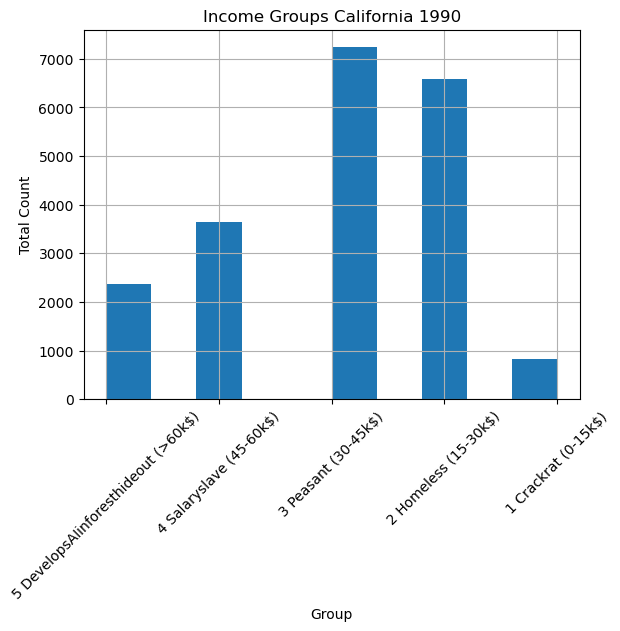

In [14]:
# Stratify our median incomes into income categories
import numpy as np
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0.,1.5,3.0,4.5,6., np.inf], labels=["1 Crackrat (0-15k$)","2 Homeless (15-30k$)","3 Peasant (30-45k$)","4 Salaryslave (45-60k$)","5 DevelopsAIinforesthideout (>60k$)"])
housing["income_cat"].hist()
plt.title("Income Groups California 1990")
plt.xlabel("Group")
plt.ylabel("Total Count")
plt.xticks(rotation=45)
plt.show()

In [15]:
# Based on our income categories, we apply a SSS to avoid bias in our small test set
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing,housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

strat_test_set["income_cat"].value_counts()/ len(strat_test_set)

3 Peasant (30-45k$)                    0.350533
2 Homeless (15-30k$)                   0.318798
4 Salaryslave (45-60k$)                0.176357
5 DevelopsAIinforesthideout (>60k$)    0.114341
1 Crackrat (0-15k$)                    0.039971
Name: income_cat, dtype: float64

In [16]:
TEST_SIZE = 0.2 
train_set, test_set = train_test_split(housing,test_size=TEST_SIZE,random_state=42)

In [17]:
# The proportions of the income_cat groups are defined as the following fractions
total_value_counts = housing["income_cat"].value_counts() / len(housing)
normal_test_value_counts = test_set["income_cat"].value_counts()/ len(test_set)
strat_test_value_counts = strat_test_set["income_cat"].value_counts()/ len(strat_test_set)
# The absolute value of their respective errors are described as 
abs_n_err = (abs((normal_test_value_counts.values)-(total_value_counts.values)))
abs_s_err = (abs((strat_test_value_counts.values)-(total_value_counts.values)))

# Convert the Series object to a DataFrame with appropriate column names
df_comparison = pd.DataFrame({
    "Income Category": total_value_counts.index,
    "Normal Proportion": total_value_counts.values,
    "Test Proportion": normal_test_value_counts.values,
    "Test Proportion Error": abs_n_err,
    "Strat Test Proportion": strat_test_value_counts.values,
    "Strat Test Proportion Error": abs_s_err
})
df_comparison

,Income Category,Normal Proportion,Test Proportion,Test Proportion Error,Strat Test Proportion,Strat Test Proportion Error
0,3 Peasant (30-45k$),0.350581,0.358527,0.007946,0.350533,0.000048
1,2 Homeless (15-30k$),0.318847,0.324370,0.005523,0.318798,0.000048
2,4 Salaryslave (45-60k$),0.176308,0.167393,0.008915,0.176357,0.000048
3,5 DevelopsAIinforesthideout (>60k$),0.114438,0.109496,0.004942,0.114341,0.000097
4,1 Crackrat (0-15k$),0.039826,0.040213,0.000388,0.039971,0.000145


In [18]:
# After using the stratisfyer category, we shall delete it from our train and test sets to avoid influence on our further procedure
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat",axis=1,inplace=True)

In [19]:
housing_buc = strat_train_set.copy()

In [20]:
# Adding some custom properties for more noteworthy metrics
housing_buc["rooms_per_household"]=housing_buc["total_rooms"]/housing_buc["households"]
housing_buc["bedrooms_per_room"]=housing_buc["total_bedrooms"]/housing_buc["total_rooms"]
housing_buc["population_per_household"]=housing_buc["population"]/housing_buc["households"]

In [21]:
# Separating the labels from the train set
housing_buc = strat_train_set.drop("median_house_value",axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [22]:
# We decide to fill the missing values with the median of the rest
median_bedrooms = housing_buc["total_bedrooms"].median()
housing_buc["total_bedrooms"].fillna(median_bedrooms,inplace=True)
print(median_bedrooms)
print(housing_buc.info())
housing_num = housing_buc.drop("ocean_proximity",axis=1)

433.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12655 to 19773
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB
None


In [23]:
from sklearn.impute import SimpleImputer
housing_num = housing_buc.drop("ocean_proximity",axis=1)
imputer = SimpleImputer(strategy="median")
imputer.fit(housing_num) # Fitting the Imputer instance to the data set


SimpleImputer(strategy='median')

In [24]:
# print(imputer.statistics_)
# print(housing_buc.median().values)
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr.info()
housing_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12655 to 19773
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12655 to 19773
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 

In [25]:

from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_buc[["ocean_proximity"]])
print(housing_cat_1hot.toarray())


[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [26]:
"""Definition of Own Transformer"""
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6
class CombinedAttributesAdder(BaseEstimator,TransformerMixin):
    def __init__(self,add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        rooms_per_household = X[:,rooms_ix]/X[:,households_ix]
        population_per_household = X[:,population_ix]/X[:,households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ix]/X[:,rooms_ix]
            return np.c_[X,rooms_per_household,population_per_household,bedrooms_per_room]
        else:
            return np.c_[X,rooms_per_household,population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing_buc.values)


In [27]:
# Pipeline for automatic data transformation
# Output is basically all we did before, but faster
# Tranforms all numerical values into the Standard-Derivation form
# Tranforms all categorical values into a OneHot-Matrix
# type(housing_prepared) = numpy.ndarray !
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("attribs_adder", CombinedAttributesAdder()),
    ("std_scaler",StandardScaler())    
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num",num_pipeline,num_attribs),
    ("cat", OneHotEncoder(),cat_attribs)
])
housing_prepared = full_pipeline.fit_transform(housing_buc)

In [28]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.svm import SVR 

svm = SVR(kernel="linear",
          C=1,
          gamma=1
          )

svm.fit(housing_prepared,housing_labels)
y_pred = svm.predict(housing_prepared)
print(np.sqrt(mse(svm.predict(housing_prepared),housing_labels)))

111095.06635291966


In [34]:
"""Systematic Search For Hyperparameters: Random Search"""
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

pd = {
        'kernel': ['linear'],
        'C': reciprocal(20, 25),
        'gamma': expon(scale=1.0),
    }

r_search = RandomizedSearchCV(
                 svm,
                 param_distributions=pd,
                 cv=2,
                 scoring="neg_mean_squared_error",
                 n_iter=1,
                 return_train_score=True,
                 random_state=42
)

r_search.fit(housing_prepared,housing_labels) # Takes a while
best_parameters = r_search.best_params_
print("Best Par: ", best_parameters)
best_estimator = r_search.best_estimator_
print("Best Est: ",best_estimator)

Best Par:  {'C': 21.743361352753134, 'gamma': 3.010121430917521, 'kernel': 'linear'}
Best Est:  SVR(C=21.743361352753134, gamma=3.010121430917521, kernel='linear')


In [ ]:
"""Cross Validation"""
# Scikit cross_val_score separates our (training) data into chunks for in-between fit check
from sklearn.model_selection import cross_val_score as cvs
scores = cvs(svm,housing_prepared,housing_labels,scoring="neg_mean_squared_error", cv=10) 
print(list(int(round(num,0)) for num in np.sqrt(-scores)))

[110518, 112957, 106999, 113591, 107783, 116064, 113279, 111837, 113169, 111945]


In [ ]:
"""Evaluation on Test Data"""
final_model = grid_search.best_estimator_
print("Model used: ", final_model)

X_test = strat_test_set.drop("median_house_value",axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

y_pred = pd.Series(final_model.predict(X_test_prepared))

final_rmse = np.sqrt(mse(y_test, y_pred))
print("RMSE :",final_rmse)


Model used:  SVR(C=1, gamma=1, kernel='linear', max_iter=15)
RMSE : 125135.32464114868


In [ ]:
from scipy import stats
confidence = 0.95
y_pred1 = y_pred.reset_index(drop=True)
y_test1 = y_test.reset_index(drop=True)
squared_errors = (y_pred1 - y_test1) ** 2
np.sqrt(stats.t.interval(confidence,len(squared_errors)-1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))
# Returns: array([46255.5950543 , 50176.43982874])
"The confidence level specified in the function is 0.95,"
"which means that there is a 95% probability that the true mean squared error falls within the calculated confidence interval."



'which means that there is a 95% probability that the true mean squared error falls within the calculated confidence interval.'